In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
import seaborn as sns

import folium
import numpy as np
from IPython.display import display

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())
full_df = pd.read_csv(root / "data" / "processed" / "state1" / "android_left.csv", header=0)
geo_cols = full_df[["eventStartLatitude", "eventStartLongitude",
                        "eventEndLatitude", "eventEndLongitude"]].copy()
full_df = full_df.drop(columns=['is_ios', 'eventType', 'eventStart', 'eventEnd'])
print(full_df.columns.tolist())
features = [
    'gyroAngleChange', 
    'gyro_angular_change_per_second',
    'radius_log',
    'turn_intensity',
    'angle_norm'
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

['eventSampleSpeed', 'eventDurationSeconds', 'eventMilesDriven', 'eventStartLatitude', 'eventStartLongitude', 'eventEndLatitude', 'eventEndLongitude', 'eventGPSSignalStrength', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'dv', 'turn_intensity', 'angle_norm', 'radius_log']
['gyroAngleChange', 'gyro_angular_change_per_second', 'radius_log', 'turn_intensity', 'angle_norm']
(124, 5)


In [3]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0

In [4]:
X_scaled = StandardScaler().fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
features_to_plot = features[:]   # keep plotting consistent with model inputs

In [5]:
# k means model
results_list = []
# possible k values
for k in [2, 3, 4, 5]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)

    results_list.append({
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k
    })    


In [6]:
N_total = X_scaled.shape[0]

In [14]:
# DBSCAN
for eps in np.linspace(0.1, 2.0, 20):
    for min_pts in range(3, 20):
        labels = DBSCAN(eps=float(eps), min_samples=int(min_pts), n_jobs=-1).fit_predict(X_scaled)
        mask = labels != -1
        labels_nn = labels[mask]
        n_clusters = len(np.unique(labels_nn))
        n_noise = int((labels == -1).sum())
        noise_pct = (n_noise / N_total) * 100.0

        if not (2 <= n_clusters <= 5) or labels_nn.size < 2:
            continue

        sil = silhouette_score(X_scaled[mask], labels_nn)
        gini = calculate_gini_score(labels)
        results_list.append({
            'model': 'dbscan',
            'HP (eps)': float(eps),
            'HP (min_samp)': int(min_pts),
            'clust. #': int(n_clusters),
            'sil. #': float(sil),
            'Gini': float(gini),
            'noise %': float(noise_pct),
        })

In [15]:
#HDBSCAN
N_total = X_scaled.shape[0]

for min_samp in range(2, 10):
    for min_cluster_size in range(8, 25):

        # Optional: prune combos that tend not to help
        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(
            min_samples=min_samp,
            min_cluster_size=min_cluster_size,
            metric='euclidean'  # explicit; change if you need
        )
        clusterer.fit(X_scaled)
        labels = clusterer.labels_

        non_noise_mask = labels != -1
        labels_non_noise = labels[non_noise_mask]
        n_non_noise = labels_non_noise.size
        n_clusters = len(np.unique(labels_non_noise)) if n_non_noise else 0

        n_noise = np.count_nonzero(labels == -1)
        noise_percentage = (n_noise / N_total) * 100.0

        # Default
        sil_score = np.nan

        # Only try silhouette when it makes sense
        if noise_percentage < 15 and n_clusters >= 2 and n_non_noise >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                # e.g., pathological spacing or degenerate cluster shapes
                sil_score = np.nan

        gini_score = calculate_gini_score(labels)  # must ignore -1 internally

        results_list.append({
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters
        })

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [16]:
results_df = pd.DataFrame(results_list)
results_df.head

<bound method NDFrame.head of         model    sil. #      Gini     noise %  clust. #  HP (eps)  \
0      kmeans  0.428595  0.451613    0.000000         2       NaN   
1      kmeans  0.312628  0.177419    0.000000         3       NaN   
2      kmeans  0.284633  0.172043    0.000000         4       NaN   
3      kmeans  0.273426  0.056452    0.000000         5       NaN   
4      dbscan  0.416968  0.421053   69.354839         2       0.6   
...       ...       ...       ...         ...       ...       ...   
1156  hdbscan       NaN  0.000000  100.000000         0       NaN   
1157  hdbscan       NaN  0.000000  100.000000         0       NaN   
1158  hdbscan       NaN  0.000000  100.000000         0       NaN   
1159  hdbscan       NaN  0.000000  100.000000         0       NaN   
1160  hdbscan       NaN  0.000000  100.000000         0       NaN   

      HP (min_samp)  HP (min_clust)  
0               NaN             NaN  
1               NaN             NaN  
2               NaN        

In [18]:
results_df = pd.DataFrame(results_list).sort_values(by=[ 'Gini', 'noise %', 'sil. #', 'clust. #',], ascending=[True,True, False, False])
filtered_results = results_df.reset_index().rename(columns={'index': 'run_id'})
filtered_results = filtered_results[filtered_results['noise %'] <= 20.0]
filtered_results = filtered_results[(filtered_results['clust. #'] >= 3)]
#filtered_results = filtered_results[filtered_results['Gini'] <= 0.9]
filtered_results = filtered_results[filtered_results['sil. #'] > 0.3]
(filtered_results.head(100))

,run_id,model,sil. #,Gini,noise %,clust. #,HP (eps),HP (min_samp),HP (min_clust)
904,1,kmeans,0.312628,0.177419,0.000000,3,NaN,NaN,NaN
1138,981,dbscan,0.336439,0.757282,16.935484,3,0.9,4.0,NaN
1141,982,dbscan,0.339450,0.764706,17.741935,3,0.9,5.0,NaN
1156,988,dbscan,0.346612,0.787037,12.903226,3,1.0,3.0,NaN


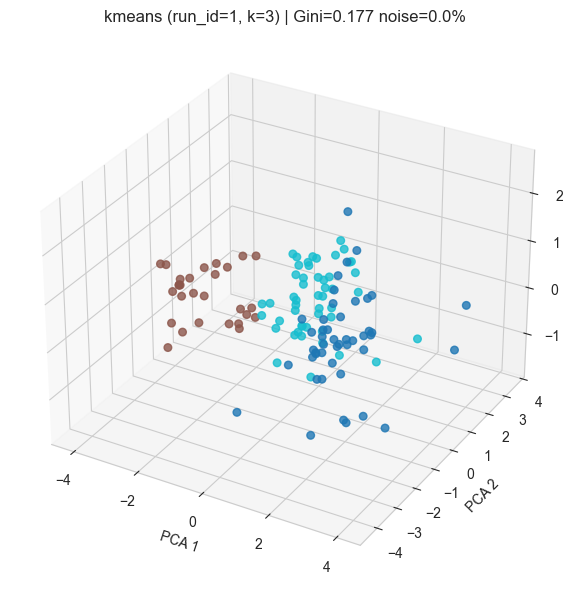

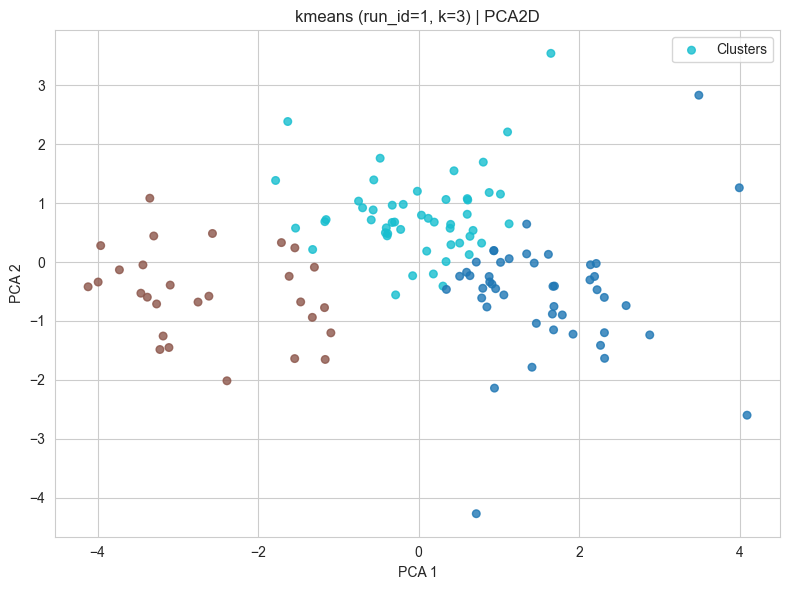

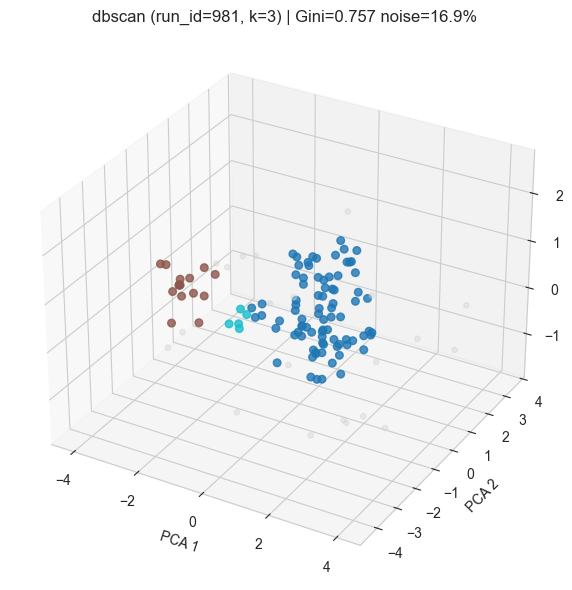

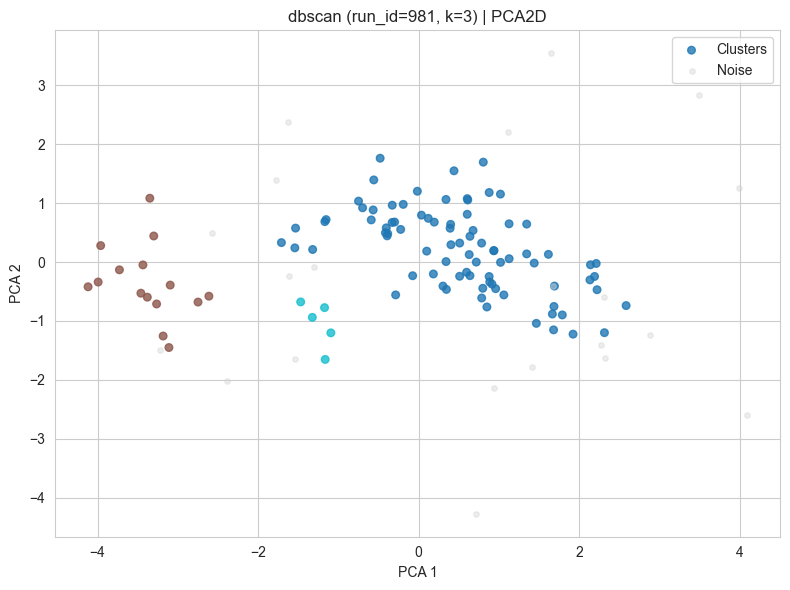

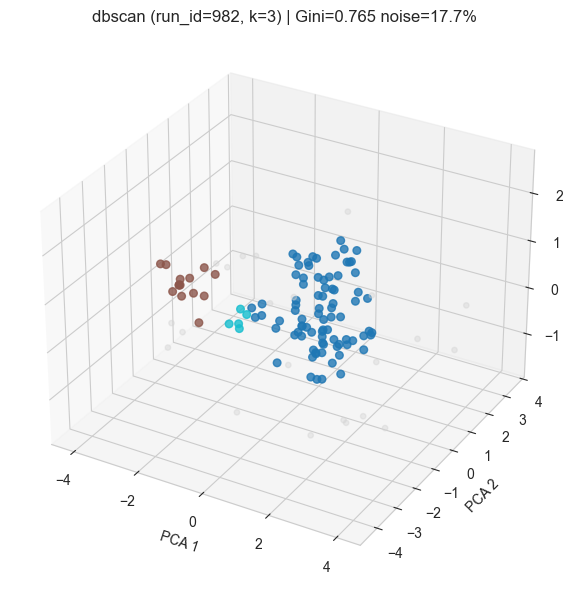

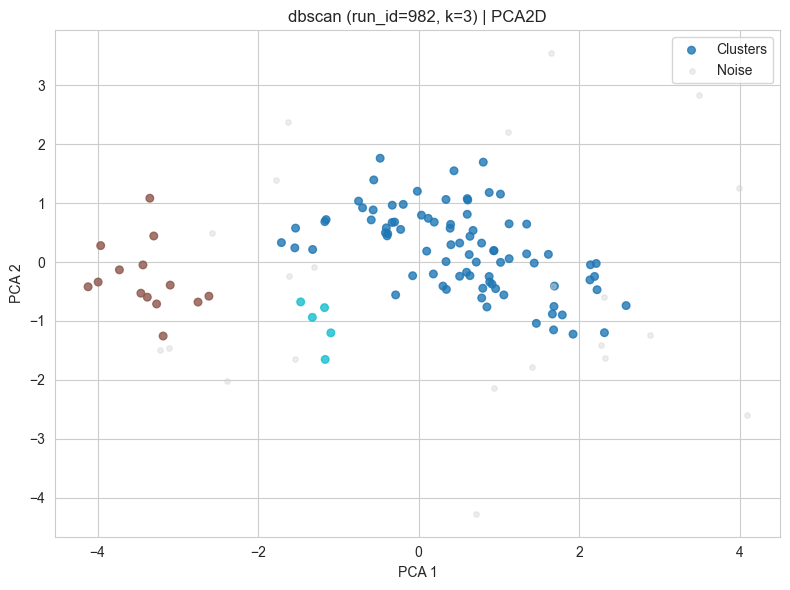

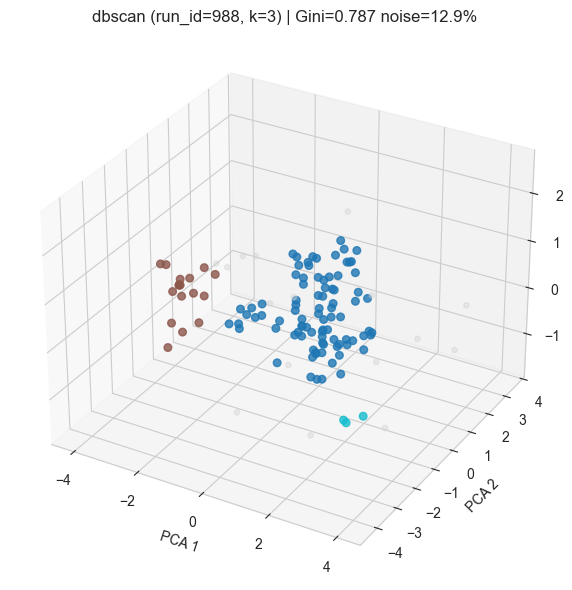

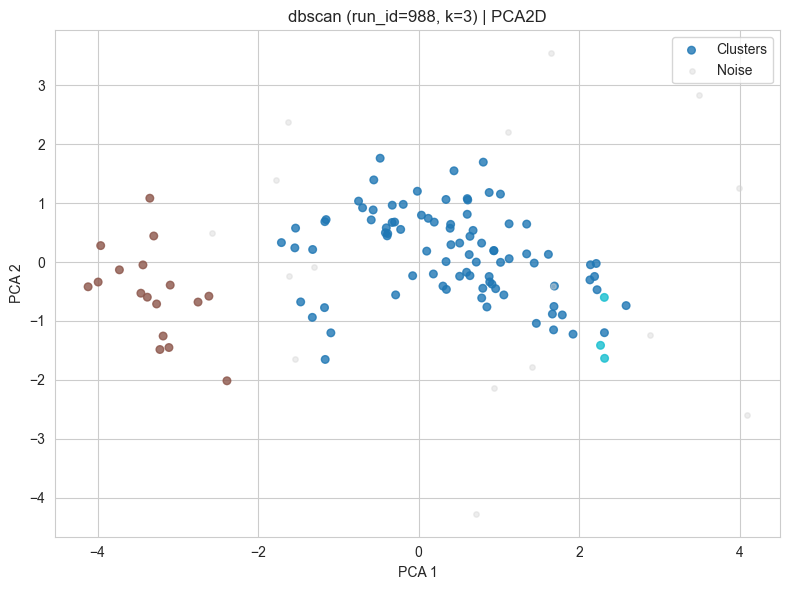

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_33684/1330006119.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


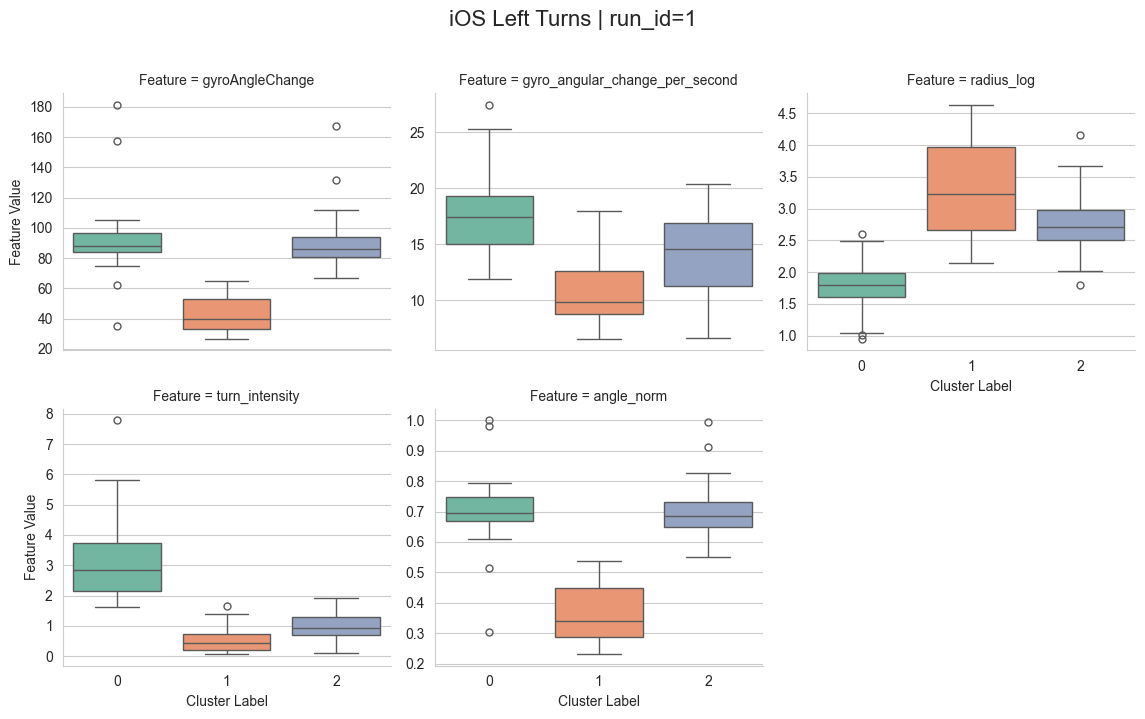

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_33684/1330006119.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


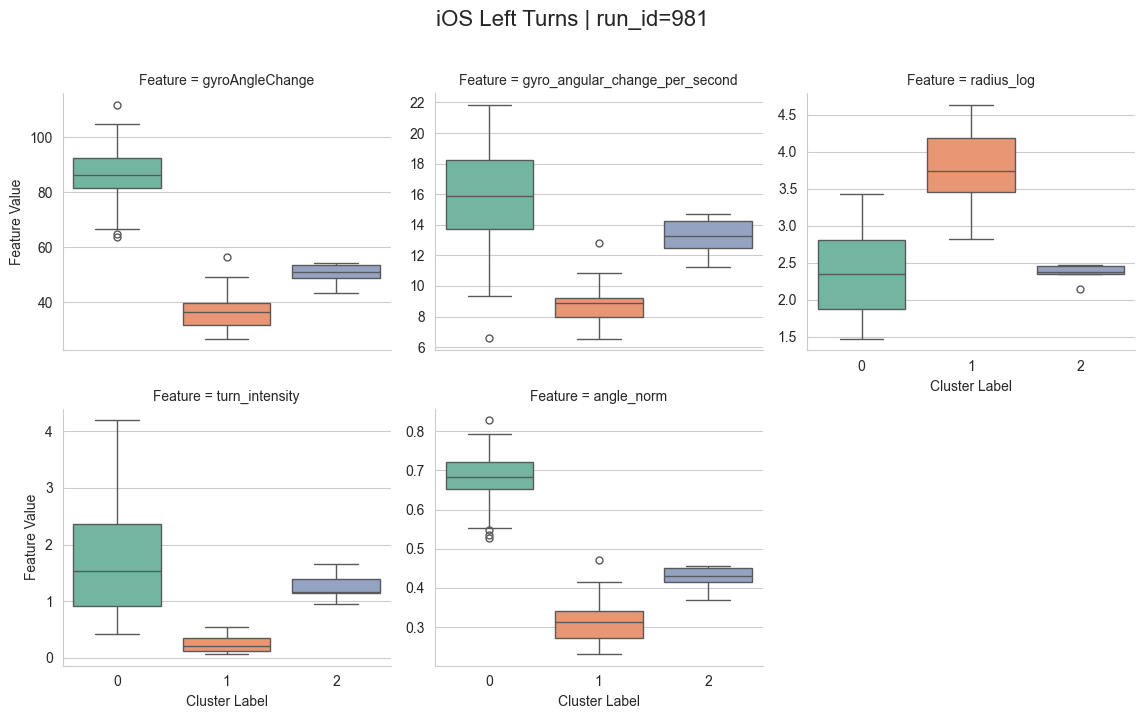

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_33684/1330006119.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


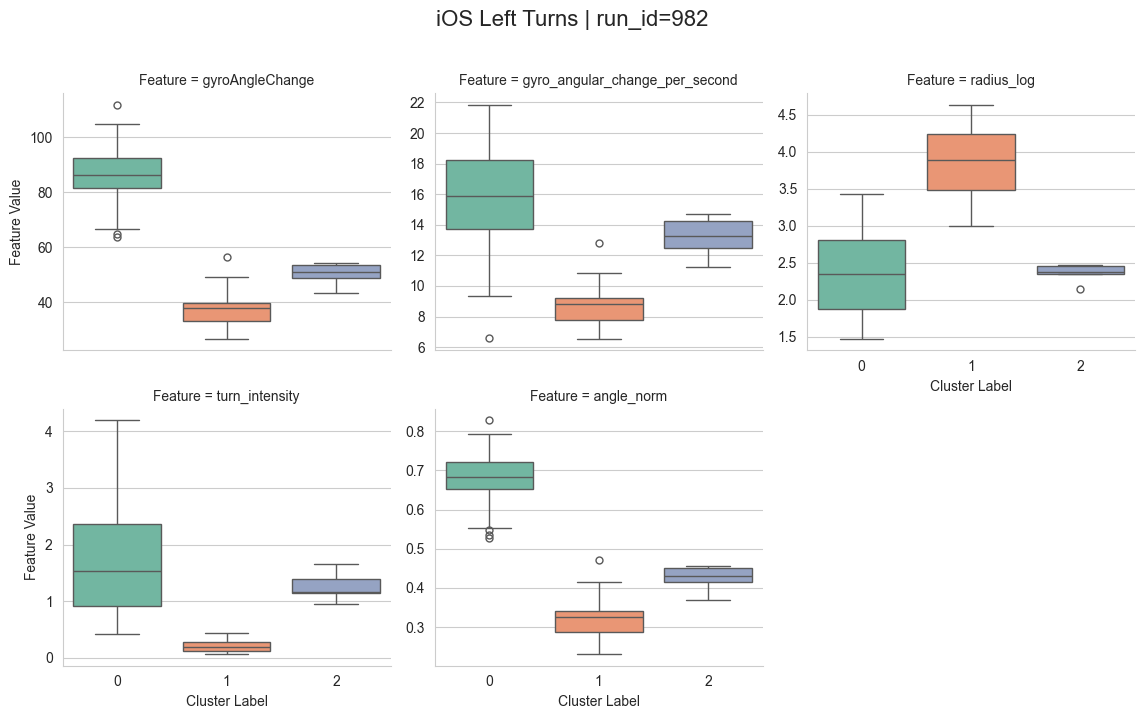

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_33684/1330006119.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


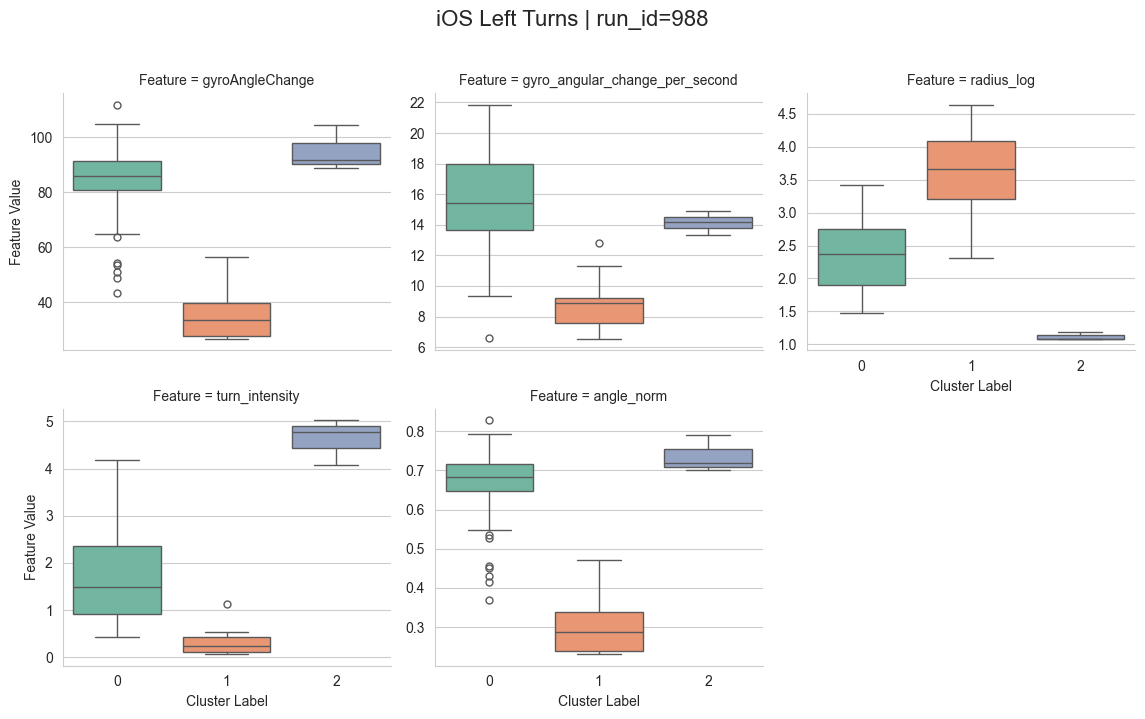

In [19]:
# --- CONFIG ---
runs_to_plot = [1, 981, 982, 988]          # run_id values you care about
plot_cols = ['gyroAngleChange',
             'gyro_angular_change_per_second',
             'radius_log',
             'turn_intensity',
             'angle_norm']

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']
    if model == 'kmeans':
        return KMeans(n_clusters=int(row['clust. #']), random_state=42)
    if model == 'dbscan':
        return DBSCAN(eps=float(row['HP (eps)']),
                      min_samples=int(row['HP (min_samp)']),
                      n_jobs=-1)
    if model == 'hdbscan':
        return hdbscan.HDBSCAN(min_samples=int(row['HP (min_samp)']),
                               min_cluster_size=int(row['HP (min_clust)'])
                               if pd.notna(row['HP (min_clust)']) else None)
    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_33684/783753294.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


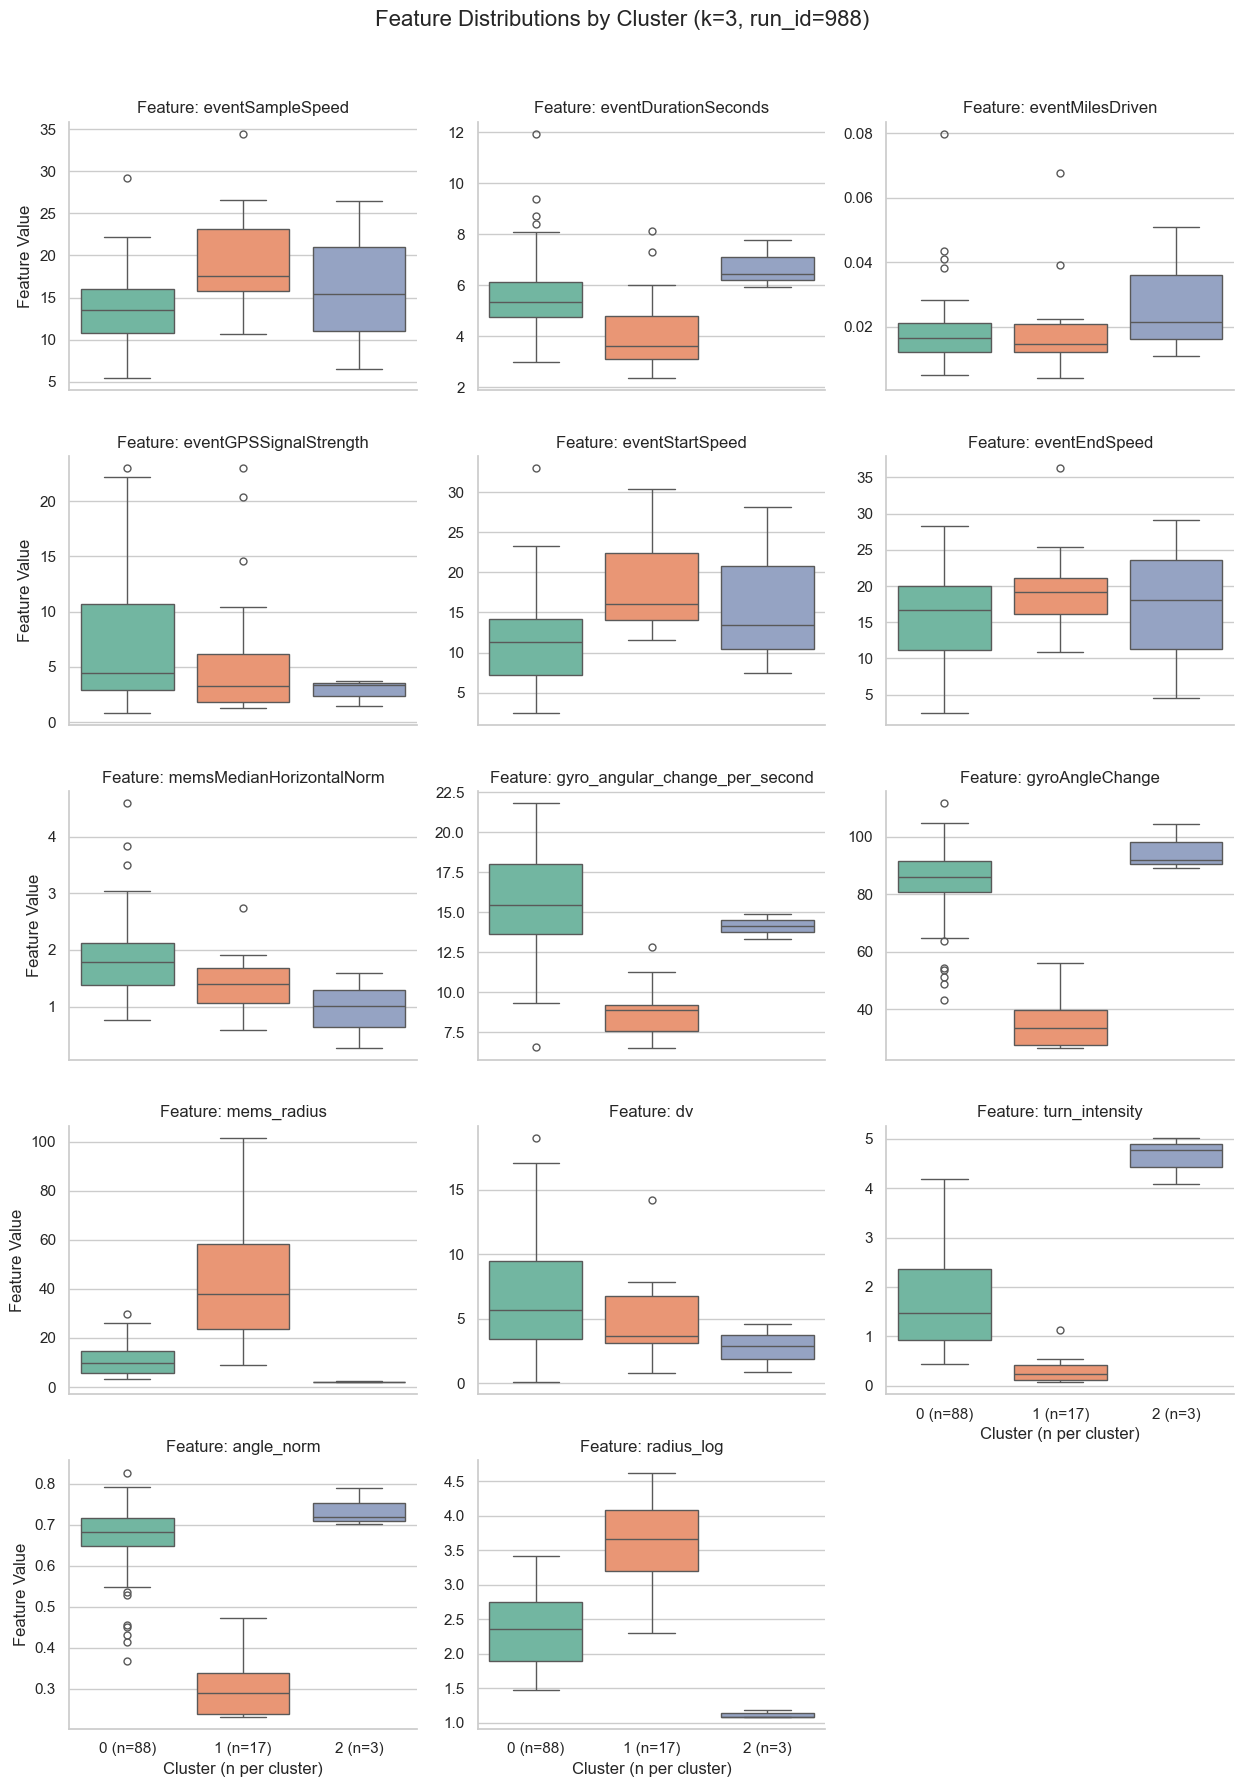

In [25]:
# --- 1) pick which dataframe to use ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels
run_id = 988
assert 'Cluster_Label' in df_with_clusters.columns, "You need to attach cluster labels first."

# --- 2) drop noise and build pretty cluster labels with counts ---
df_plot = df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()
counts = df_plot['Cluster_Label'].value_counts().sort_index()
label_map = {cl: f"{int(cl)} (n={int(counts.loc[cl])})" for cl in counts.index}
df_plot['Cluster_Str'] = df_plot['Cluster_Label'].map(label_map)

# keep a stable order on x-axis
ordered_xticks = [label_map[cl] for cl in sorted(counts.index)]
df_plot['Cluster_Str'] = pd.Categorical(df_plot['Cluster_Str'], categories=ordered_xticks, ordered=True)

# --- 3) select features to visualize (exclude IDs/GPS/labels) ---
excluded = {'Cluster_Label','Cluster_Str','eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude'}
features_to_plot = [c for c in df_plot.columns if c not in excluded and pd.api.types.is_numeric_dtype(df_plot[c])]

# --- 4) reshape to long form for seaborn ---
df_melted = df_plot.melt(
    id_vars='Cluster_Str',
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)

# --- 5) plot ---
sns.set(style='whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Cluster_Str',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=3,
    height=3.5,
    aspect=1.2,
    sharey=False,
    palette='Set2'
)

k = len(counts)
g.fig.suptitle(f'Feature Distributions by Cluster (k={k}, run_id={run_id})', y=1.02, fontsize=16)
g.set_titles('Feature: {col_name}')
g.set_axis_labels('Cluster (n per cluster)', 'Feature Value')
plt.tight_layout()
plt.show()

In [21]:
# --- CONFIG ---
run_id = 988  # <-- change to your target run
gps_cols = ['eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude']

# --- 0) Safety checks ---
assert 'run_id' in filtered_results.columns, "No run_id column in filtered_results. Did you reset_index() earlier?"
assert all(c in full_df.columns for c in gps_cols), "GPS columns not found in full_df."

# --- 1) Select the run row ---
sel = filtered_results.loc[filtered_results['run_id'] == run_id]
if sel.empty:
    raise ValueError(f"run_id {run_id} not found in filtered_results.")
row = sel.iloc[0]
model = row['model']

# --- 2) Rebuild the exact clusterer ---
if model == 'dbscan':
    eps = float(row['HP (eps)'])
    min_samp = int(row['HP (min_samp)'])
    clusterer = DBSCAN(eps=eps, min_samples=min_samp)
elif model == 'hdbscan':
    min_samp = int(row['HP (min_samp)'])
    min_clust = int(row['HP (min_clust)']) if pd.notna(row.get('HP (min_clust)')) else None
    clusterer = hdbscan.HDBSCAN(min_samples=min_samp, min_cluster_size=min_clust)
elif model == 'kmeans':
    nclust = int(row['clust. #'])
    clusterer = KMeans(n_clusters=nclust, random_state=42)
else:
    raise ValueError(f"Unknown model '{model}'")

# --- 3) Fit on the SAME X_scaled used for that run ---
# (assumes X_scaled aligns 1:1 with df's index)
labels = clusterer.fit_predict(X_scaled)

# --- 4) Build a fresh frame with labels (don't mutate df) ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels

# --- 5) Reattach GPS by index (no reorder) ---
#df_with_clusters = df_with_clusters.join(full_df[gps_cols])

# --- 6) Optional: drop noise & rows missing GPS ---
plot_df = df_with_clusters.copy()
plot_df = plot_df[plot_df['Cluster_Label'] != -1]  # uncomment to hide noise
plot_df = plot_df.dropna(subset=gps_cols)

# --- 7) Sanity checks ---
assert 'Cluster_Label' in plot_df.columns, "Cluster_Label not present after join."
assert plot_df.shape[0] > 0, "No rows to plot (check GPS availability / noise filter)."

print("Ready: df_with_clusters has labels + GPS. Rows:", df_with_clusters.shape[0])
print("Plot rows:", plot_df.shape[0])
print("Features", plot_df.columns.tolist())

Ready: df_with_clusters has labels + GPS. Rows: 124
Plot rows: 108
Features ['eventSampleSpeed', 'eventDurationSeconds', 'eventMilesDriven', 'eventStartLatitude', 'eventStartLongitude', 'eventEndLatitude', 'eventEndLongitude', 'eventGPSSignalStrength', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'dv', 'turn_intensity', 'angle_norm', 'radius_log', 'Cluster_Label']


In [22]:
# --- CONFIG ---
cluster_to_plot = 0
gps_cols = ['eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude']

# filter one cluster
single = plot_df.loc[plot_df['Cluster_Label'] == cluster_to_plot].dropna(subset=gps_cols).copy()
if single.empty:
    raise ValueError(f"No rows found for cluster {cluster_to_plot}")

# ensure optional columns exist
for col in ['eventStartSpeed','eventEndSpeed',
            'gyroAngleChange','gyro_angular_change_per_second',
            'angle_norm','curvature','turn_intensity','radius_log']:
    if col not in single.columns:
        single[col] = np.nan

# center & map
m = folium.Map(
    location=[single['eventStartLatitude'].mean(), single['eventStartLongitude'].mean()],
    zoom_start=14, control_scale=True, tiles='cartodbpositron'
)

color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b'][cluster_to_plot % 6]

for _, r in single.iterrows():
    # polyline
    folium.PolyLine(
        locations=[[r['eventStartLatitude'], r['eventStartLongitude']],
                   [r['eventEndLatitude'],   r['eventEndLongitude']]],
        color=color, weight=3, opacity=0.9,
        tooltip=(f"Cluster {cluster_to_plot} | "
                 f"Start {r['eventStartSpeed']:.1f} mph → End {r['eventEndSpeed']:.1f} mph")
    ).add_to(m)

    # start marker with rich popup
    popup_html = (
        f"<b>Cluster:</b> {cluster_to_plot}<br>"
        f"<b>Start speed:</b> {r['eventStartSpeed']:.1f} mph<br>"
        f"<b>End speed:</b> {r['eventEndSpeed']:.1f} mph<br>"
        f"<b>Δgyro angle:</b> {r['gyroAngleChange']:.1f}°<br>"
        f"<b>Angular rate:</b> {r['gyro_angular_change_per_second']:.1f}°/s<br>"
        f"<b>angle_norm:</b> {r['angle_norm']:.2f}<br>"
        f"<b>curvature:</b> {r['curvature']:.3f}<br>"
        f"<b>turn_intensity:</b> {r['turn_intensity']:.2f}<br>"
        f"<b>radius_log:</b> {r['radius_log']:.2f}"
    )
    folium.CircleMarker(
        [r['eventStartLatitude'], r['eventStartLongitude']],
        radius=3, color='black', fill=True, fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

    # end point
    folium.CircleMarker(
        [r['eventEndLatitude'], r['eventEndLongitude']],
        radius=3, color=color, fill=True, fill_opacity=0.9
    ).add_to(m)

display(m)
# m.save(f"cluster_{cluster_to_plot}.html")

In [23]:
# --- CONFIG ---
cluster_to_plot = 1
gps_cols = ['eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude']

# filter one cluster
single = plot_df.loc[plot_df['Cluster_Label'] == cluster_to_plot].dropna(subset=gps_cols).copy()
if single.empty:
    raise ValueError(f"No rows found for cluster {cluster_to_plot}")

# ensure optional columns exist
for col in ['eventStartSpeed','eventEndSpeed',
            'gyroAngleChange','gyro_angular_change_per_second',
            'angle_norm','curvature','turn_intensity','radius_log']:
    if col not in single.columns:
        single[col] = np.nan

# center & map
m = folium.Map(
    location=[single['eventStartLatitude'].mean(), single['eventStartLongitude'].mean()],
    zoom_start=14, control_scale=True, tiles='cartodbpositron'
)

color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b'][cluster_to_plot % 6]

for _, r in single.iterrows():
    # polyline
    folium.PolyLine(
        locations=[[r['eventStartLatitude'], r['eventStartLongitude']],
                   [r['eventEndLatitude'],   r['eventEndLongitude']]],
        color=color, weight=3, opacity=0.9,
        tooltip=(f"Cluster {cluster_to_plot} | "
                 f"Start {r['eventStartSpeed']:.1f} mph → End {r['eventEndSpeed']:.1f} mph")
    ).add_to(m)

    # start marker with rich popup
    popup_html = (
        f"<b>Cluster:</b> {cluster_to_plot}<br>"
        f"<b>Start speed:</b> {r['eventStartSpeed']:.1f} mph<br>"
        f"<b>End speed:</b> {r['eventEndSpeed']:.1f} mph<br>"
        f"<b>Δgyro angle:</b> {r['gyroAngleChange']:.1f}°<br>"
        f"<b>Angular rate:</b> {r['gyro_angular_change_per_second']:.1f}°/s<br>"
        f"<b>angle_norm:</b> {r['angle_norm']:.2f}<br>"
        f"<b>curvature:</b> {r['curvature']:.3f}<br>"
        f"<b>turn_intensity:</b> {r['turn_intensity']:.2f}<br>"
        f"<b>radius_log:</b> {r['radius_log']:.2f}"
    )
    folium.CircleMarker(
        [r['eventStartLatitude'], r['eventStartLongitude']],
        radius=3, color='black', fill=True, fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

    # end point
    folium.CircleMarker(
        [r['eventEndLatitude'], r['eventEndLongitude']],
        radius=3, color=color, fill=True, fill_opacity=0.9
    ).add_to(m)

display(m)
# m.save(f"cluster_{cluster_to_plot}.html")

In [24]:
# --- CONFIG ---
cluster_to_plot = 2
gps_cols = ['eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude']

# filter one cluster
single = plot_df.loc[plot_df['Cluster_Label'] == cluster_to_plot].dropna(subset=gps_cols).copy()
if single.empty:
    raise ValueError(f"No rows found for cluster {cluster_to_plot}")

# ensure optional columns exist
for col in ['eventStartSpeed','eventEndSpeed',
            'gyroAngleChange','gyro_angular_change_per_second',
            'angle_norm','curvature','turn_intensity','radius_log']:
    if col not in single.columns:
        single[col] = np.nan

# center & map
m = folium.Map(
    location=[single['eventStartLatitude'].mean(), single['eventStartLongitude'].mean()],
    zoom_start=14, control_scale=True, tiles='cartodbpositron'
)

color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b'][cluster_to_plot % 6]

for _, r in single.iterrows():
    # polyline
    folium.PolyLine(
        locations=[[r['eventStartLatitude'], r['eventStartLongitude']],
                   [r['eventEndLatitude'],   r['eventEndLongitude']]],
        color=color, weight=3, opacity=0.9,
        tooltip=(f"Cluster {cluster_to_plot} | "
                 f"Start {r['eventStartSpeed']:.1f} mph → End {r['eventEndSpeed']:.1f} mph")
    ).add_to(m)

    # start marker with rich popup
    popup_html = (
        f"<b>Cluster:</b> {cluster_to_plot}<br>"
        f"<b>Start speed:</b> {r['eventStartSpeed']:.1f} mph<br>"
        f"<b>End speed:</b> {r['eventEndSpeed']:.1f} mph<br>"
        f"<b>Δgyro angle:</b> {r['gyroAngleChange']:.1f}°<br>"
        f"<b>Angular rate:</b> {r['gyro_angular_change_per_second']:.1f}°/s<br>"
        f"<b>angle_norm:</b> {r['angle_norm']:.2f}<br>"
        f"<b>curvature:</b> {r['curvature']:.3f}<br>"
        f"<b>turn_intensity:</b> {r['turn_intensity']:.2f}<br>"
        f"<b>radius_log:</b> {r['radius_log']:.2f}"
    )
    folium.CircleMarker(
        [r['eventStartLatitude'], r['eventStartLongitude']],
        radius=3, color='black', fill=True, fill_opacity=0.9,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

    # end point
    folium.CircleMarker(
        [r['eventEndLatitude'], r['eventEndLongitude']],
        radius=3, color=color, fill=True, fill_opacity=0.9
    ).add_to(m)

display(m)
# m.save(f"cluster_{cluster_to_plot}.html")